# Pyramid: A Layered Model for Nested Named Entity Recognition - GENIA Experiment

This notebook tries to reproduce the experiments on the GENIA dataset in [Pyramid: A Layered Model for Nested Named Entity Recognition](https://www.aclweb.org/anthology/2020.acl-main.525.pdf). Keep in mind that the split that I was able to recover on the web, is not the same used by the authors (the original dataset is not free), but the distribution is very close. The notebook includes a brief data analysis section to quantitavely assess this difference.

**Turn on the GPUs!**

## Downloading Code, PubMed Word Embeddings and BioBERT

In [ ]:
!git clone https://github.com/federico-giannoni/pyramid-nested-ner.git
!mv pyramid-nested-ner/* . && rm -rf pyramid-nested-ner # move to root

In [ ]:
!cd genia && ./prepare.sh

In [ ]:
!pip install flair seqeval 2>&1 > /dev/null

In [ ]:
from genia.utils.load_wv import get_bio_word_vectors
from pyramid_nested_ner.model import PyramidNer
from pyramid_nested_ner.modules.word_embeddings.transformer_embeddings import TransformerWordEmbeddings
from pyramid_nested_ner.modules.word_embeddings.pretrained_embeddings import PretrainedWordEmbeddings
from pyramid_nested_ner.data.dataset import PyramidNerDataset
from pyramid_nested_ner.utils.data import rasa_data_reader
from pyramid_nested_ner.training.trainer import PyramidNerTrainer
from pyramid_nested_ner.training.optim import get_default_sgd_optim
from scipy.stats import norm
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import json

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Exploratory Data Analysis

For comparison, here are the statistics reported for the splits used in the paper (look at GENIA):
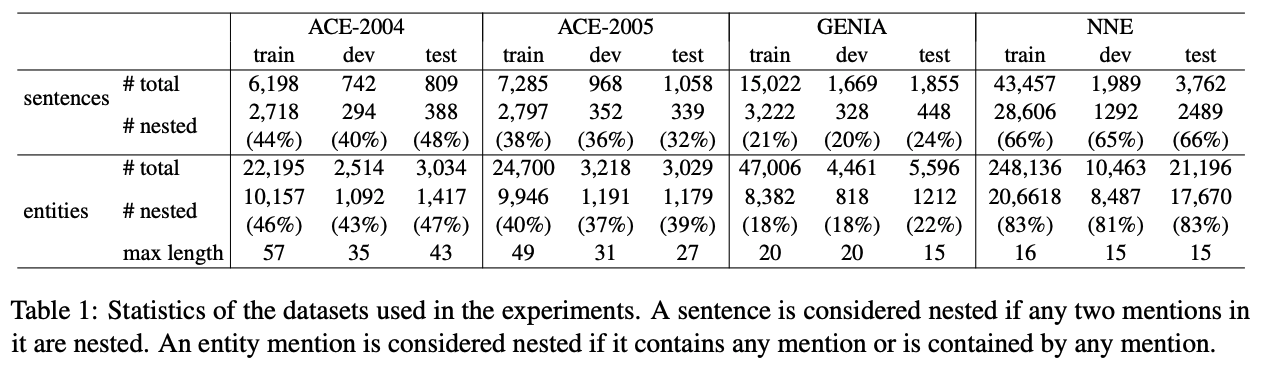

In [ ]:
def load_genia_split(split='train'):
  return json.load(open(f'/content/genia/data/rasa/genia.{split}.rasa', 'r'))['rasa_nlu_data']['common_examples']

train, test, dev = load_genia_split('train'), load_genia_split('test'), load_genia_split('dev')

In [ ]:
def plot_histogram(df, bins=20, title=None):
  fig, axes = plt.subplots(len(df.index), 2, figsize=(16, 24))
  if title:
    fig.suptitle(title, fontsize=24, y=1.01)
  for i, col in enumerate(df.columns):
    for j, (_, row) in enumerate(df.iterrows()):
      view = np.array(row[col])
      axes[j, i].set_title(f"{df.index.values[j]} {col}")
      axes[j, i].hist(view, bins=bins, density=True)
      x = np.arange(view.min(), view.max() + 1)
      axes[j, i].plot(
        x, norm.pdf(x, view.mean(), view.std())
      )
  fig.tight_layout(pad=3.0)

In [ ]:
def piecharts(*pies, titles=None, fig_title=None):
  titles = titles or [" - " for pie in pies]
  fig, axes = plt.subplots(1, len(pies), figsize=(21, 8))

  def autopct_func(pct, allvals):
    absolute = round(pct/100.*np.sum(list(allvals)))
    return "{:.1f}% ({:.0f})".format(pct,  absolute)

  for (ax, pie, title) in zip(axes, pies, titles):
    ax.pie(pie.values(), wedgeprops=dict(width=0.75), startangle=90, labels=pie.keys(), autopct=lambda pct: autopct_func(pct, pie.values()))
    ax.set_title(title, fontsize=18)

  fig.suptitle(fig_title, fontsize=24)

### Label Lexicon and Distribution

In [ ]:
train_entities = [entity['entity'] for sample in train for entity in sample['entities']]
test_entities = [entity['entity'] for sample in test for entity in sample['entities']]
dev_entities  = [entity['entity'] for sample in dev  for entity in sample['entities']]

In [ ]:
print(f"""
  * Train set entities:\t{len(train_entities)};
  * Test set entities:\t{len(test_entities)};
  * Dev set entities: \t{len(dev_entities)};
""")


  * Train set entities:	45929;
  * Test set entities:	5474;
  * Dev set entities: 	4337;



In [ ]:
counts = list()
for dataset_entities in [train_entities, test_entities, dev_entities]:
  counts.append({e: dataset_entities.count(e) for e in set(dataset_entities)})

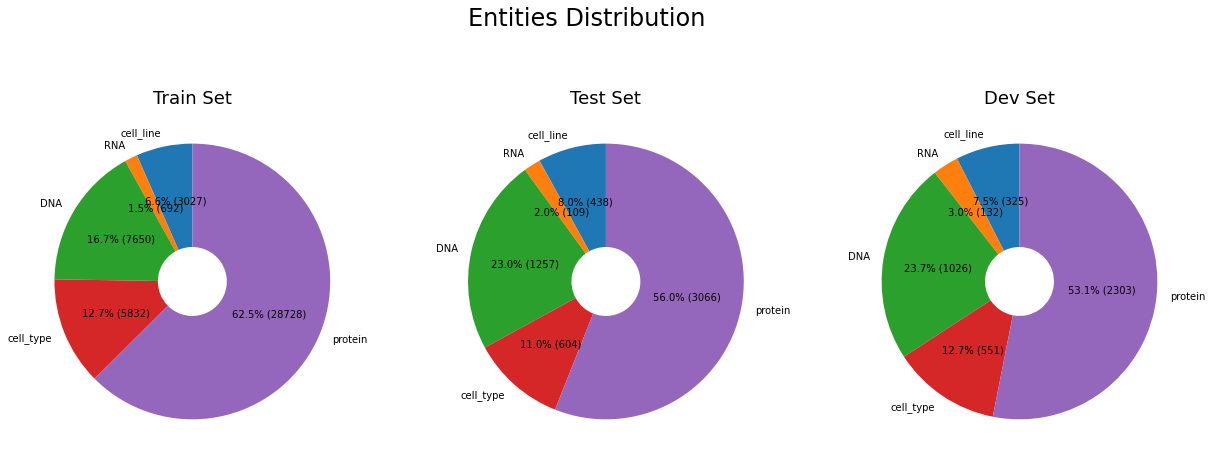

In [ ]:
piecharts(*counts, titles=['Train Set', 'Test Set', 'Dev Set'], fig_title='Entities Distribution')

### Entities Spans Insights

In [ ]:
def entities_length(data):
  token_lengths = dict()
  chars_lengths = dict()
  for sample in data:
    for entity in sample['entities']:
      e = entity['entity']
      if e not in token_lengths:
        token_lengths[e] = list()
        chars_lengths[e] = list()
      chars_lengths[e].append(len(entity['value']))
      token_lengths[e].append(len(entity['value'].split()) + 1)

  assert list(chars_lengths.keys()) == list(token_lengths.keys())

  keys = chars_lengths.keys()
  
  return pd.DataFrame(
    index=keys, 
    data={'chars' : np.array([*chars_lengths.values()]), 
          'tokens': np.array([*token_lengths.values()])}
  )

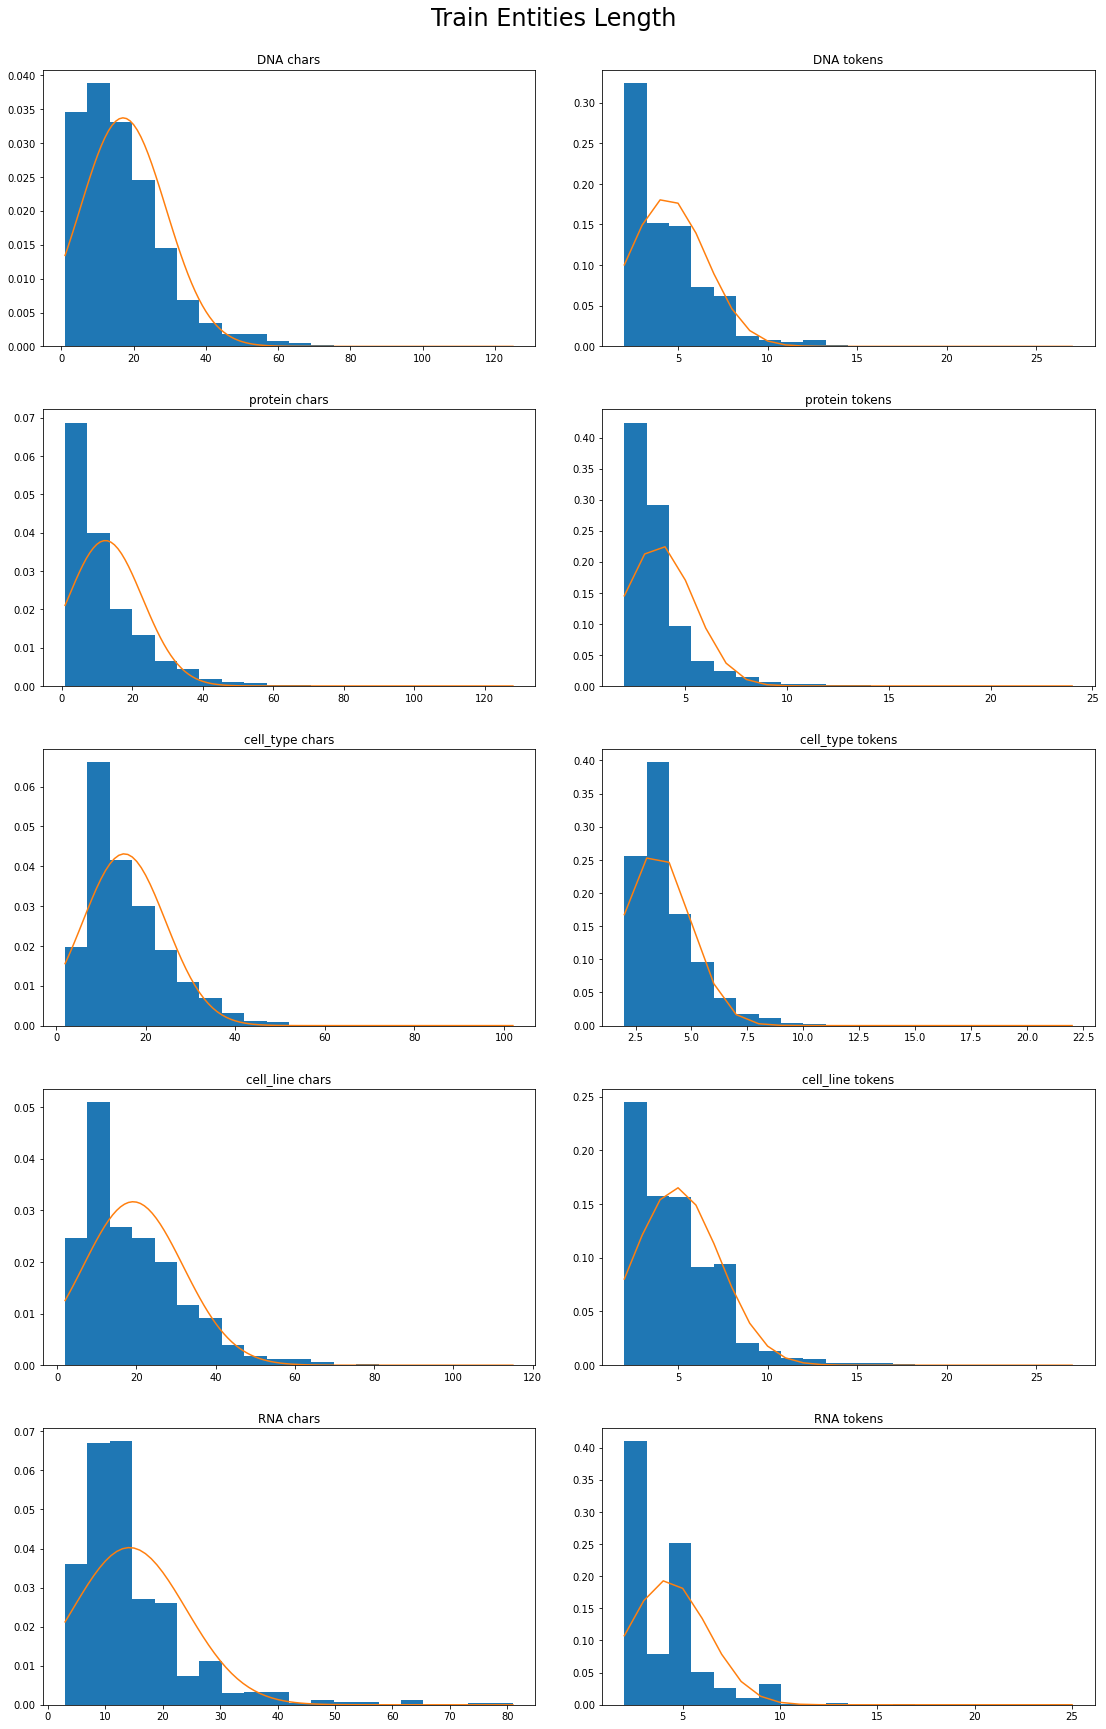

In [ ]:
plot_histogram(entities_length(train), title='Train Entities Length')

### Nesting and Overlap Analysis

In [ ]:
def assess_entities_overlap(example):
  overlaps = 0
  nestings = 0
  entities = 0
  
  bitmap = np.zeros(len(example['text']))

  for entity in sorted(example['entities'], key=lambda e: (e['start'], -e['end'])):
    region = bitmap[entity['start']:entity['end']]
    if not np.max(region):
      entities += 1  # normal entity
    else:
      if np.min(region) == np.max(region):
        nestings += 1  # entity contained entirely by a longer one
      else:
        overlaps += 1  # entity partially overlapping with another
    
    bitmap[entity['start']:entity['end']] += 1.
  
  return entities, overlaps, nestings

In [ ]:
dataset_insights = []

for dataset in [train, test, dev]:
  
  entities_insights = {'nestings': 0, 'overlaps': 0, 'flat': 0}

  for example in dataset:
    flat, overlaps, nestings = assess_entities_overlap(example)
    entities_insights['nestings'] += nestings
    entities_insights['overlaps'] += overlaps
    entities_insights['flat'] += flat
  
  dataset_insights.append(deepcopy(entities_insights))

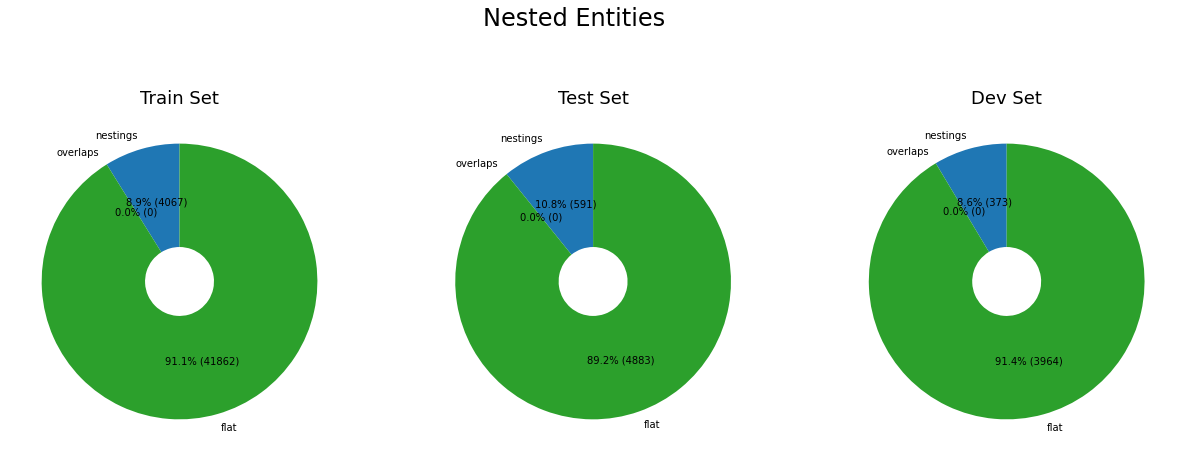

In [ ]:
piecharts(*dataset_insights, titles=['Train Set', 'Test Set', 'Dev Set'], fig_title='Nested Entities')

I consider an entity a **nested mention** when it is **entirely contained in the span of a longer entity**. When two spans are only partially overlapping, then I consider the two entities as **overlapping**. As you can see from the chart above, the dataset only contains nested mentions, and no overlapping mentions, however, the Pyramid model is capable of extracting overlapping as well as nested entity mentions.

## Experiments Setup

Loading the word embeddings and the lexicon, then prepare the data loaders.


In [ ]:
lexicon, word_embeddings_weights = get_bio_word_vectors('genia/data/bio_nlp_vec/PubMed-shuffle-win-2.bin')

In [ ]:
train_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.train.rasa'), 
  pyramid_max_depth=15,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True,
    batch_size=64,
    device=DEVICE, 
    bucketing=True
)

test_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.test.rasa'), 
  pyramid_max_depth=15,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True, 
    batch_size=16,
    device=DEVICE, 
    bucketing=True
)

dev_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.dev.rasa'), 
  pyramid_max_depth=15,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True, 
    batch_size=16,
    device=DEVICE, 
    bucketing=True
)

## Experiment 1: Pyramid Basic

Just the standard 15-layers pyramid (plus one extra layer for the remedy solution). We use character embeddings and PubMed word embeddings. We do not fine-tune the word embeddings.

In [ ]:
pyramid_ner = PyramidNer(
  word_lexicon=lexicon,
  entities_lexicon=train_entities,
  word_embeddings=PretrainedWordEmbeddings(word_embeddings_weights, padding_idx=0, freeze=True),
  language_model=None,
  char_embeddings_dim=60,
  encoder_hidden_size=100,
  encoder_output_size=200,
  decoder_hidden_size=100,
  batch_first=True,
  inverse_pyramid=False,
  custom_tokenizer=None,
  pyramid_max_depth=15,
  decoder_dropout=0.4,
  encoder_dropout=0.4,
  device=DEVICE,
)

trainer = PyramidNerTrainer(pyramid_ner)

In [ ]:
optimizer, scheduler = get_default_sgd_optim(pyramid_ner.nnet.parameters())
ner_model, report = trainer.train(
  train_data, 
  optimizer=optimizer, 
  scheduler=scheduler, 
  restore_weights_on='loss',
  epochs=60, 
  dev_data=dev_data, 
  patience=np.inf, 
  grad_clip=5.0
)

In [ ]:
report.plot_loss_report()

In [ ]:
report.plot_custom_report('micro_f1')

In [ ]:
print(trainer.test_model(test_data, out_dict=False))

## Experiment 2: Pyramid Full

Bidirectional 15-layers pyramid (plus one extra layer for the remedy solution). We use character embeddings and PubMed word embeddings. We do not fine-tune the word embeddings.

In [ ]:
pyramid_ner = PyramidNer(
  word_lexicon=lexicon,
  entities_lexicon=train_entities,
  word_embeddings=PretrainedWordEmbeddings(word_embeddings_weights, padding_idx=0, freeze=True),
  language_model=None,
  char_embeddings_dim=60,
  encoder_hidden_size=100,
  encoder_output_size=200,
  decoder_hidden_size=100,
  batch_first=True,
  inverse_pyramid=True,
  custom_tokenizer=None,
  pyramid_max_depth=15,
  decoder_dropout=0.4,
  encoder_dropout=0.4,
  device=DEVICE,
)

trainer = PyramidNerTrainer(pyramid_ner)

In [ ]:
optimizer, scheduler = get_default_sgd_optim(pyramid_ner.nnet.parameters())
ner_model, report = trainer.train(
  train_data, 
  optimizer=optimizer, 
  scheduler=scheduler, 
  restore_weights_on='loss',
  epochs=60, 
  dev_data=dev_data, 
  patience=np.inf, 
  grad_clip=5.0
)

In [ ]:
report.plot_loss_report()

In [ ]:
report.plot_custom_report('micro_f1')

In [ ]:
print(trainer.test_model(test_data, out_dict=False))

## Experiment 3: Pyramid Full + BioBERT

Bidirectional 15-layers pyramid (plus one extra layer for the remedy solution). We use character embeddings, PubMed word embeddings and BioBERT word embeddings obtained from the token embeddings using [Flair](https://github.com/zalandoresearch/flair). We do not fine-tune neither of the word embeddings.

In [ ]:
pyramid_ner = PyramidNer(
  word_lexicon=lexicon,
  entities_lexicon=train_entities,
  word_embeddings=PretrainedWordEmbeddings(word_embeddings_weights, padding_idx=0, freeze=True),
  language_model='/content/genia/data/biobert_large',
  char_embeddings_dim=60,
  encoder_hidden_size=100,
  encoder_output_size=200,
  decoder_hidden_size=100,
  batch_first=True,
  inverse_pyramid=True,
  custom_tokenizer=None,
  pyramid_max_depth=15,
  decoder_dropout=0.4,
  encoder_dropout=0.4,
  device=DEVICE,
)

trainer = PyramidNerTrainer(pyramid_ner)

In [ ]:
optimizer, scheduler = get_default_sgd_optim(pyramid_ner.nnet.parameters())
ner_model, report = trainer.train(
  train_data, 
  optimizer=optimizer, 
  scheduler=scheduler, 
  restore_weights_on='loss',
  epochs=60, 
  dev_data=dev_data, 
  patience=np.inf, 
  grad_clip=5.0
)

In [ ]:
report.plot_loss_report()

In [ ]:
report.plot_custom_report('micro_f1')

In [ ]:
print(trainer.test_model(test_data, out_dict=False))

## Experiment 4: Shallow Pyramid Basic

This is an extra-experiment not performed in the paper to test out the **new implementation of the remedy solution**. In the paper, the remedy solution allows the model to capture entity mentions longer than the depth of the pyramid, but only if these mentions are not nested. **By re-formulating the problem in a multi-label setting, I've extended the remedy solution to also capture nested mentions that are longer than the depth of the Pyramid.**

As highlighted in the paper, reducing the depth of the pyramid obviously reduces the discriminative power of the model. However, it also reduces the number of parameters and makes **inferece feasible on CPU**.

Basic 2-layers pyramid (plus one extra layer for the remedy solution). We use character embeddings and PubMed word embeddings. We do not fine-tune the word embeddings.

In [ ]:
train_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.train.rasa'), 
  pyramid_max_depth=2,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True,
    batch_size=64,
    device=DEVICE, 
    bucketing=True
)

test_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.test.rasa'), 
  pyramid_max_depth=2,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True, 
    batch_size=16,
    device=DEVICE, 
    bucketing=True
)

dev_data = PyramidNerDataset(
  rasa_data_reader('/content/genia/data/rasa/genia.dev.rasa'), 
  pyramid_max_depth=2,
  token_lexicon=lexicon,
  custom_tokenizer=None, 
  char_vectorizer=True,
).get_dataloader(
    shuffle=True, 
    batch_size=16,
    device=DEVICE, 
    bucketing=True
)

In [ ]:
pyramid_ner = PyramidNer(
  word_lexicon=lexicon,
  entities_lexicon=train_entities,
  word_embeddings=PretrainedWordEmbeddings(word_embeddings_weights, padding_idx=0, freeze=True),
  language_model=None,
  char_embeddings_dim=60,
  encoder_hidden_size=100,
  encoder_output_size=200,
  decoder_hidden_size=100,
  batch_first=True,
  inverse_pyramid=True,
  custom_tokenizer=None,
  pyramid_max_depth=2,
  decoder_dropout=0.2,
  encoder_dropout=0.2,
  device=DEVICE,
)

trainer = PyramidNerTrainer(pyramid_ner)

In [ ]:
optimizer, scheduler = get_default_sgd_optim(pyramid_ner.nnet.parameters())
ner_model, report = trainer.train(
  train_data, 
  optimizer=optimizer, 
  scheduler=scheduler, 
  restore_weights_on='loss',
  epochs=60, 
  dev_data=dev_data, 
  patience=np.inf, 
  grad_clip=5.0
)

In [ ]:
report.plot_loss_report()

In [ ]:
report.plot_custom_report('micro_f1')

In [ ]:
print(trainer.test_model(test_data, out_dict=False))